In [1]:
from comet_ml.api import API
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

# comet_api = API(api_key="w7QuiECYXbNiOozveTpjc9uPg")
# experiments = comet_api.get(workspace="tensorized-rnn", project_name="digit-classification")

def fetch_val_eer(experiments, cores_result_dict):
    for exp in experiments:
        tags = exp.get_tags()
        tag = tags[-1]
        
        if tag in cores_result_dict.keys():
            # best validation eer is the last one recorded.
            best_val_eer_dict = exp.get_metrics("best_eer")[-1]
            best_val_eer = float(best_val_eer_dict['metricValue'])
            # best_val_eer_step = int(best_val_eer_dict['step'])
            
            cores_result_dict[tag].append(best_val_eer)
    print(cores_result_dict)
    
    # average results of experiment repeats.
    cores_avg_result_dict = {}
    for tag, eer_list in cores_result_dict.items():
        print("Tag: {}. No of experiments: {}".format(tag, len(eer_list)))
        cores_avg_result_dict[tag] = round(np.mean(eer_list) * 100, 2) 
        
    return cores_avg_result_dict


def safely_get_parameter(api_exp, param_name):
    param_list = api_exp.get_parameters_summary(param_name)
    if len(param_list) == 0:
        raise ValueError("parameter '{}' was not found in experiment '{}'"
                         .format(param_name, api_exp.get_metadata()["experimentKey"]))
    return param_list["valueCurrent"]

def get_max_value_of_metric(api_exp, metric_key):
    metric_vals = api_exp.get_metrics(metric_key)
    max_val = 0
    for metric_val in metric_vals:
        metric_as_float = float(metric_val['metricValue'])
        if metric_as_float > max_val:
            max_val = metric_as_float
    
    return max_val

def tt_num_params(in_core_shape, out_core_shape, rank, bias=True):
    # number of parameters in a tt linear layer.
    assert len(in_core_shape) == len(out_core_shape)
    n_cores = len(in_core_shape)
    
    result = 0
    out_size = 1
    for i in range(n_cores):
        if i == 0 or i == n_cores - 1:
            result += rank * (in_core_shape[i]) * out_core_shape[i]
        else:
            result += rank**2 * (in_core_shape[i]) * out_core_shape[i]
        out_size *= out_core_shape[i]
    
    if bias:
        result += out_size
    return result

def tt_lstm_num_params(num_layers, hidden_core_shape, input_core_shape, rank, bias=True):
    # number of parameters in a tt lstm.
    n_gates_and_cell = 4
    result = 0
    
    # layer 1
    result = 4 * (tt_num_params(input_core_shape, hidden_core_shape, rank, False) 
                      + tt_num_params(hidden_core_shape, hidden_core_shape, rank, bias))
    
    # for higher layers, input_size == hidden_size
    if num_layers > 1:
        num_layers_minus_1 = num_layers - 1
        result += num_layers_minus_1 * 4 * (tt_num_params(hidden_core_shape, hidden_core_shape, rank, False) 
                      + tt_num_params(hidden_core_shape, hidden_core_shape, rank, bias))
    
    return result

def lstm_num_params(num_layers, hidden_size, input_size, bias=True):
    n_gates_and_cell = 4
    result = 0
    
    # layer 1
    result = 4 * ((input_size + hidden_size + int(bias)) * hidden_size)
    
    # for higher layers, input_size == hidden_size
    if num_layers > 1:
        num_layers_minus_1 = num_layers - 1
        result += num_layers_minus_1 * 4 * ((hidden_size + hidden_size + int(bias)) * hidden_size)
    
    return result

def tt_lstm_num_params_with_concattrick(num_layers, hidden_shape, hidden_out_shape, input_shape, rank, bias=True):
    # number of parameters in a tt lstm that uses concatenation trick.
    n_gates_and_cell = 4
    result = 0
    
    # layer 1
    result = (tt_num_params(input_shape, hidden_out_shape, rank, False) 
                      + tt_num_params(hidden_shape, hidden_out_shape, rank, bias))
    
    # for higher layers, input_size == hidden_size
    if num_layers > 1:
        num_layers_minus_1 = num_layers - 1
        result += num_layers_minus_1 * (tt_num_params(hidden_shape, hidden_out_shape, rank, False) 
                      + tt_num_params(hidden_shape, hidden_out_shape, rank, bias))
    
    return result

In [2]:
a = lstm_num_params(2, 32, 28, bias=True) + 32 * 10 + 10
b = tt_lstm_num_params_with_concattrick(2, (2, 4, 4), (4, 4, 8), (2, 2, 7), 2, bias=True)
print(b + 32 * 10 + 10)

1178


## Model Configuration (update if model changes)

In [21]:
def get_input_core_shape(n_cores):
    # input is of size 28
    if n_cores == 2:
        shape = (4, 7)
    elif n_cores == 3:
        shape = (2, 2, 7)
    else:
        raise ValueError("cores value not supported.")
    return shape

def get_hidden_core_shape(n_cores):
    # hidden size of 32
    if n_cores == 2:
        raise ValueError("cores value not supported.")
    elif n_cores == 3:
        shape = (2, 4, 4)
    else:
        raise ValueError("cores value not supported.")
    return shape

def get_hidden_out_core_shape(n_cores):
    # hidden size of 32
    if n_cores == 2:
        raise ValueError("cores value not supported.")
    elif n_cores == 3:
        shape = (4, 4, 8)
    else:
        raise ValueError("cores value not supported.")
    return shape

def get_nlayers_in_model():
    return 2

NameError: name 'experiments' is not defined

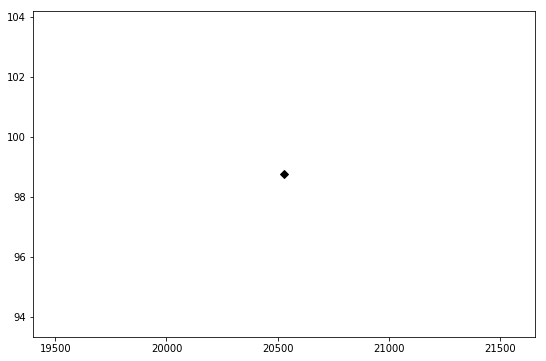

In [7]:
def create_dict_with_tt_results():
    """ Load test accuracies according to ranks and no of cores """
    
    # dict with "key: n-cores", "value: dict of (key: rank, value: test_eer)"
    experiments_result_dict = {2: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 8:0, 10:0, 12:0, 14:0},
                              3: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 8:0, 10:0, 12:0, 14:0}}

    for exp in experiments:    
        use_tt = exp.get_parameters_summary("ttlstm")["valueCurrent"]
        if not use_tt: continue

        try:
            n_cores = int(safely_get_parameter(exp, "ncores"))
            tt_rank = int(safely_get_parameter(exp, "ttrank"))
            best_test_acc = get_max_value_of_metric(exp, "test_accuracy")
        except Exception as e:
            print(e)
            continue

        if n_cores not in experiments_result_dict \
                or tt_rank not in experiments_result_dict[n_cores]:
            print("Skipping experiment: use_tt={}, n_cores={}, tt_rank={}".format(use_tt, n_cores, tt_rank))
            continue
        experiments_result_dict[n_cores][tt_rank] = best_test_acc
    return experiments_result_dict

### PlOT THE RESULTS
plt.figure(figsize=(9, 6))
in_size = 256
out_size = 256

# plot uncompressed experiment.
plt.plot(20530, 98.77, "D", label="uncompressed", color='black', linewidth=3)

# plot tt experiments.
experiments_result_dict = create_dict_with_tt_results()
for k, v in experiments_result_dict.items():
    # get no of params for each rank
    input_core_shape = get_input_core_shape(k)
    hidden_core_shape = get_hidden_core_shape(k)
    n_layers = get_nlayers_in_model()
    param_counts = [tt_lstm_num_params(n_layers, hidden_core_shape, input_core_shape, rank, bias=True)
                    for rank in v.keys()]
    print("TT-{}cores params: {}".format(len(hidden_core_shape), param_counts))
    
    param_counts = [tt_lstm_num_params2(n_layers, hidden_core_shape, input_core_shape, rank, bias=True)
                    for rank in v.keys()]
    print("TT-{}cores params: {}".format(len(hidden_core_shape), param_counts))
    
    # plot test accuracy of each tt experiment
    plt.plot(param_counts, v.values(), "-o", label="tt-lstm ({} cores)".format(len(hidden_core_shape)))
plt.xscale('log')
plt.xlabel('no of parameters', fontsize=14)
plt.ylabel('test accuracy', fontsize=14)
plt.ylim([85, 100])
plt.xlim([1e3, 1e5])
plt.legend(fontsize=12)
plt.show()

In [12]:
experiments_result_dict = create_dict_with_results()
print(experiments_result_dict)

Skipping experiment: use_tt=true, n_cores=2, tt_rank=8
Skipping experiment: use_tt=true, n_cores=3, tt_rank=8
{2: {1: 95.98999786376953, 2: 96.76000213623047, 3: 97.16999816894531, 4: 97.47000122070312, 5: 97.66000366210938, 6: 98.0}, 3: {1: 92.06999969482422, 2: 95.11000061035156, 3: 96.4000015258789, 4: 96.8499984741211, 5: 97.48999786376953, 6: 98.22000122070312}}


In [13]:
20416 - 17344

3072